In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# 1. EDA
- Visualize sample
- Number of datasets
- Image stats (Size distributions)
- Image simiarity

## 1. Visualize samples

In [4]:
num_of_images = 5
def show_n_images(num_of_images, path, folder, label):
    """
    return: Show n images from the path/folder/label
    """

    images = os.listdir(os.path.join(path, folder, label))
    plt.figure(figsize=(15, 5))

    for i in range(num_of_images):
        plt.subplot(2, 5, i+1)
        img = cv2.imread(os.path.join(path, folder, label, images[i]))
        plt.imshow(img)
        plt.title(str(i+1))
        plt.axis('off')    
    plt.suptitle(label)      
    plt.show()

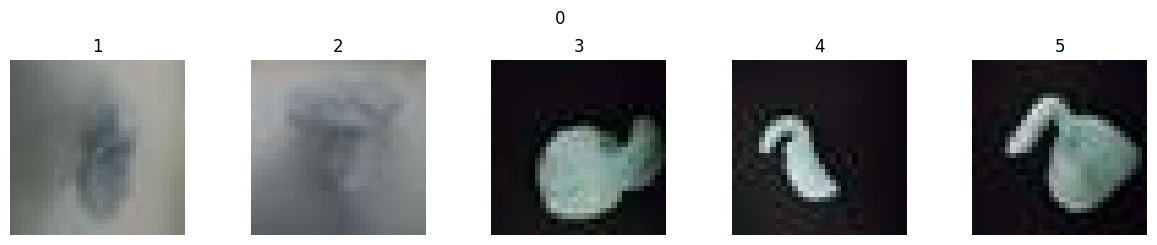

In [5]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

show_n_images(num_of_images, path, folders[0], labels[0])

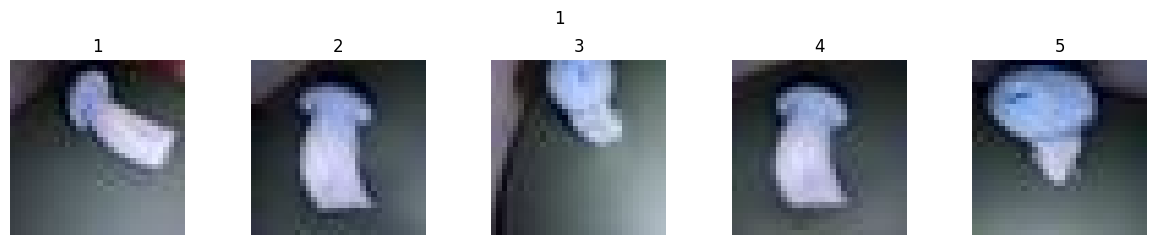

In [6]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

show_n_images(num_of_images, path, folders[0], labels[1])

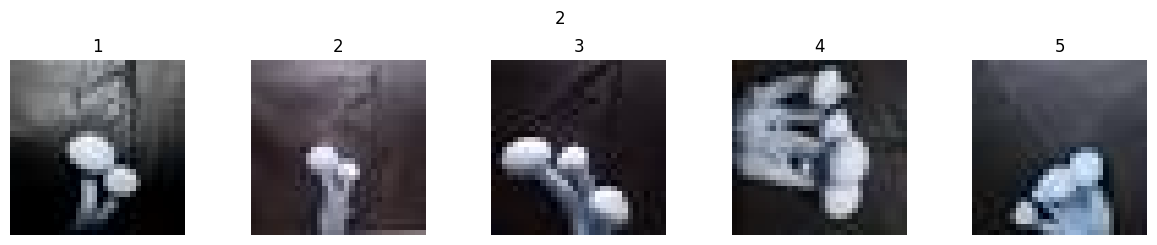

In [7]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

show_n_images(num_of_images, path, folders[0], labels[2])

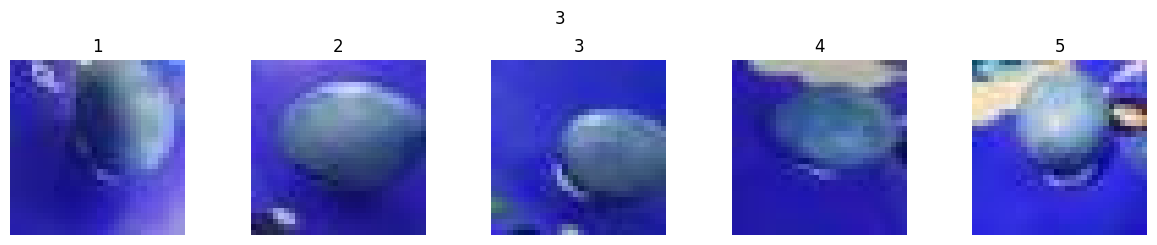

In [8]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

show_n_images(num_of_images, path, folders[0], labels[3])

## 2. number of datasets

In [9]:
def data_info(path, folders, labels):
    """
    return: dataframe contains number of images in each folder
    """
    stats = {
        "train": [],
        "val": [],
        "test": []
    }

    for f in folders:
        for l in labels:
            images = os.listdir(os.path.join(path, f, l))
            stats[f].append(len(images))    

    df = pd.DataFrame(stats, index=labels)
    return df

   train  val  test
0    180   30    90
1    180   30    90
2    180   30    90
3    180   30    90


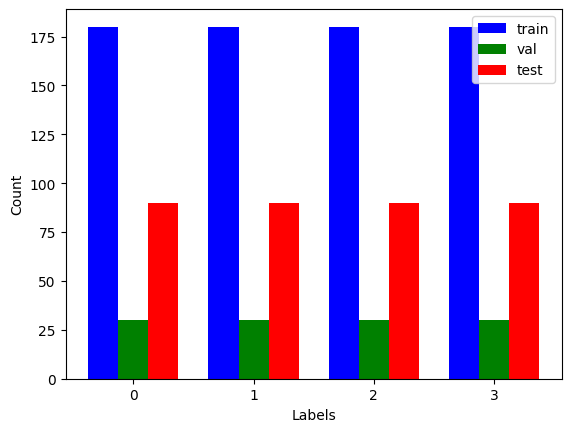

In [14]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

df = data_info(path, folders, labels)
print(df)

x = np.arange(len(df.index))
width = 0.25

length = len(labels)
# setup width of bar, then offset using "width"
plt.bar(np.array(range(0, length)) - width, df["train"], width=width, color='b', label='train')
plt.bar(x, df["val"], width=width, color='g', label='val')
plt.bar(x + width, df["test"], width=width, color='r', label='test')

plt.xticks(x, df.index)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.legend()
plt.show()

## 3. Image stats (size distributions)

In [15]:
from collections import Counter

def plot_distribution(path, folders, labels):
    """
    return: plot distribution of width, height, and ratio of images
    """
    width_dis = [] # save width size
    height_dis = [] # save height size
    ratio_dis = [] # save ratio

    for f in folders:
        for l in labels:
            images = os.listdir(os.path.join(path, f, l))
            for i in images:
                img = cv2.imread(os.path.join(path, f, l, i))

                # save stats
                width_dis.append(img.shape[1])
                height_dis.append(img.shape[0])
                ratio_dis.append(img.shape[1]/img.shape[0])

    # plot subplots, each subplot is a histogram
    fig, axes = plt.subplots(1, 3, figsize=(10, 6))
    most_common_width = Counter(width_dis).most_common(1)[0][0]
    most_common_height = Counter(height_dis).most_common(1)[0][0]
    most_common_ratio = Counter(ratio_dis).most_common(1)[0][0]
    print(most_common_width, most_common_height, most_common_ratio)

    axes[0].hist(width_dis, bins=100)
    axes[0].set_xlabel("Width size")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Width size distribution")

    axes[1].hist(height_dis, bins=100)
    axes[1].set_xlabel("Height size")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Height size distribution")

    axes[2].hist(ratio_dis, bins=100)
    axes[2].set_xlabel("Ratio")
    axes[2].set_ylabel("Frequency")
    axes[2].set_title("Ratio distribution")
    plt.show()

32 32 1.0


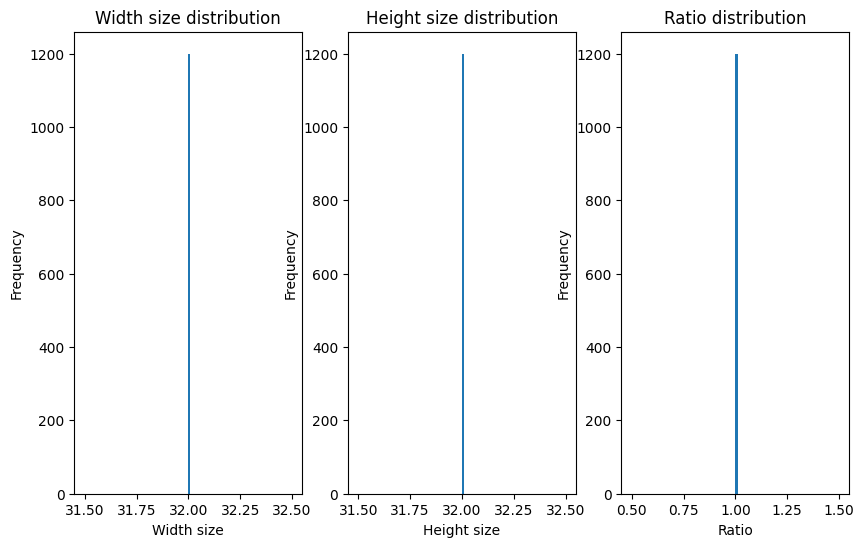

In [16]:
path = "../data"
folders = ["train", "val", "test"]
labels = ["0", "1", "2", "3"]

plot_distribution(path, folders, labels)